In [11]:
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns;sns.set()
os.getcwd()

'c:\\Users\\enrik\\Desktop\\Mabomba\\Studie\\MasterCS\\Thesis\\code\\plot_notebooks'

## Load and plot wms vs cond ent

['finalbestofstates2.pkl', 'finalbestofstates3.pkl', 'finalbestofstates4.pkl']
Index(['systemID', 'parX', 'pX', 'syn_upper', 'H(Xi)', 'I(X1;X2)', 'shapeS',
       'lenS', 'tot_runtime', 'syn_info', 'srv_data', 'pXS', 'steps', 'lenX',
       'states', 'sample method', 'I(X1;X2) level', 'H(X0)', 'H(X1)', 'H(S)',
       'I(X;S)', 'I(Xi;S)', 'WMS(X;S)', 'H(Sfound|Sym)', 'H(Sfound|bestof)',
       'H(Sfound|Smin)'],
      dtype='object')


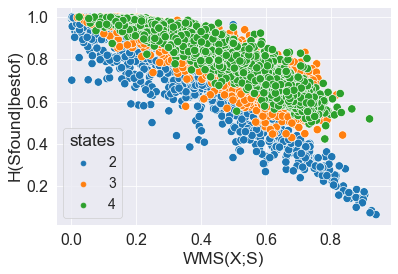

In [12]:
types = ['random','first','full','syndisc']
data = {'systemID':[],'parX':[],'upper':[],'totmi':[],'indivmi':[],'runtime':[],'exp_sort':[]}

# load and concatenate data for states = 2,3,4
folder = '../../results/rq32/'
os.chdir(folder)
allfiles = glob.glob("*.pkl")
files = [file for file in allfiles if 'finalbestofstates' in file]
if len(files) != 0:
    print(files)
    d=pd.concat([pd.read_pickle(f) for f in files])
os.chdir('../../code/plot_notebooks')

print(d.keys())
sns.set_context("paper", font_scale = 1.8, rc={"legend.fontsize": 14})
g = sns.scatterplot(data=d,x='WMS(X;S)',y='H(Sfound|bestof)',hue='states',s=70,palette='tab10')
fig = g.get_figure()